In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'OTHER', 'PESSIMISTIC', 'WORRIED'])]

df

,text,function
209,I'm fairly pessimistic about it,PESSIMISTIC
210,I'm fairly pessimistic,PESSIMISTIC
211,I'm pessimistic about it,PESSIMISTIC
212,I'm pessimistic,PESSIMISTIC
213,I'm rather sceptical about it,PESSIMISTIC
...,...,...
897,you could do it,OTHER
898,you look nice,OTHER
899,you look smart,OTHER
900,you're right,OTHER


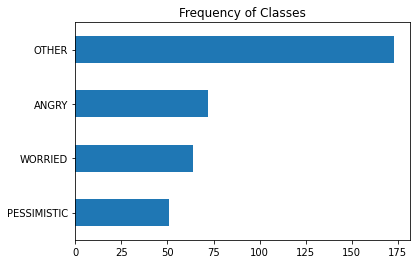

In [3]:
import matplotlib.pyplot as plt

df["function"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [4]:
function_mapping = {'OTHER': ['joy', 'love', 'surprise'],
           'NOT_INTERESTED': [''], 
           'DISLIKE':[''], 
           'NOT_CORRECT': [''], 
           'PESSIMISTIC':['sadness'], 
           'WORRIED':['fear'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': [''], 
           'BORED': [''], 
           'NOT_APPROVE':[''], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': [''], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

emotion = load_dataset('emotion')
mapping = {
    0:"sadness",
    1:"joy",
    2:"love",
    3:"anger",
    4:"fear",
    5:"surprise"
}
emotion = emotion.map(lambda example: {'emotion': mapping[example['label']]}, 
                      remove_columns=['label'])
def map_labels(batch):
    batch['function'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["function"]):
        for key, value in function_mapping.items():
            for emotion in value:
                if emotion == batch["emotion"][i]:
                    batch["function"][i] = key
                    break
    return batch
emotion = emotion.map(map_labels, batched=True)

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████| 3/3 [00:00<00:00, 64.96it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-da33b75eb48814c5.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-c9fa37d993431ea5.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-9e625d0ab4c5791f.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c6709727

In [5]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)).shuffle(seed=42),
    "valid": emotion['validation'],
    "test": emotion['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'function'],
        num_rows: 360
    })
    valid: Dataset({
        features: ['text', 'emotion', 'function'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'emotion', 'function'],
        num_rows: 2000
    })
})

In [6]:
dataset['train'][0]

{'text': "don't you think so?", 'function': 'OTHER'}

In [7]:
dataset = dataset.class_encode_column("function")
labels = dataset['train'].features['function']
dataset = dataset.rename_column("function", "label")
print(labels.names)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-390eecc66e407e1e.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-ca76f14b12e0a0c9.arrow


['ANGRY', 'OTHER', 'PESSIMISTIC', 'WORRIED']


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'cardiffnlp/twitter-xlm-roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

ds_enc = dataset.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
ds_enc

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 360
    })
    valid: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'emotion', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [9]:
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [10]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = "functions_basic_finetuning"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,        
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],                    
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/njfernandez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 360
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 60
  Number of trainable parameters = 278046724
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.303640,0.120375,0.250000,0.162504
2,No log,1.257117,0.120375,0.250000,0.162504
3,No log,1.254394,0.120375,0.250000,0.162504
4,No log,1.236448,0.263367,0.269009,0.198608
5,No log,1.222556,0.381868,0.292075,0.228586


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotion, text. If emotion, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to functions_basic_finetuning/checkpoint-12
Configuration saved in functions_basic_finetuning/checkpoint-12/config.json
Model weights saved in functions_basic_finetuning/checkpoint-12/pytorch_model.bin
tokenizer config file saved in functions_basic_finetuning/checkpoint-12/tokenizer_config.json
Special tokens file saved in functions_basic_finetuning/checkpoint-12/special_tokens_map.json
Deleting older checkpoint [functions_basic_finetuning/checkpoint-60] due to args.save_total_limit
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along d

TrainOutput(global_step=60, training_loss=1.0344611485799153, metrics={'train_runtime': 97.0005, 'train_samples_per_second': 18.557, 'train_steps_per_second': 0.619, 'total_flos': 13875246216000.0, 'train_loss': 1.0344611485799153, 'epoch': 5.0})

In [ ]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotion, text. If emotion, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****


In [ ]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

In [ ]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_functions_basic_emotion_finetuning.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):    
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(50, 50))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}
    plt.rc('font', **font)
    ax.tick_params(axis='x', which='major', labelsize=15)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(ds_enc["test"]["label"])
plot_confusion_matrix(y_preds, y_valid, labels.names)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")     
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
ds_enc["test"] = ds_enc["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

In [ ]:
ds_enc.set_format("pandas")
cols = ["text", 'emotion', "label", "predicted_label", "loss"]
df_test = ds_enc["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
dataset["train"][2]

In [ ]:
ds_enc["test"][:][cols]["predicted_label"]

In [ ]:
df_test["predicted_label"][0:50]

In [ ]:
loss_values = df_test.sort_values("loss", ascending=False).head(50)
loss_values

In [ ]:
loss_values.to_csv('loss_values_functions_basic_emotion_finetuning.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_functions_basic_emotion_finetuning.tsv',header =True, sep = '\t',index=False)